In [1]:
import sys
sys.path.insert(0, '../')
%load_ext autoreload
%autoreload 2
from lib.utils import check_exists, run_python, run_matlab, get_solution_result_folder_address, \
                        get_solution_result_file_address, solver_name_to_n_iter
import os
import scipy.io
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.font_manager import FontProperties
import math
from lib.plot import *
from lib.result_analysis import *

# Data

## Setting

In [2]:
solver_list = ["ADMM", "Gurobi", "Mosek"]
VOT_list = [2.63, 1.315]
percNonUVal_list = [95, 90, 85, 80]
budget_list = [200, 800, 2000, 10000]
seed_data = 2
seed_solver = 2
seed_ADMM = 2
fairness = "0_0_0_100_0" # Corresponds to RHSMultiplier = [1, 1.1, 1.5, 2, 2.5]
n_time_inc_start = 13
n_time_inc_end = 24
step_size_UE = 0.01
n_iter_UE = 250
region_ = "region_y3_div"
setting_region = "6_9_AVG5_th1_pad_MultipleTimes"
n_iter_ADMM = 15000
rho = 20
MIPGap = 0.01
factor_cost_comparison = 10
combine_2_3_5_companies = False

## Load Data

In [3]:
solver_solution_dict = {}
n_deviated_dict = {}
solver_cost_dict = {}
solver_cost_dict_2_3_5 = {}
for solver_name, VOT, percNonUVal, budget in itertools.product(solver_list, VOT_list, percNonUVal_list, budget_list):
#     n_iter_ADMM = 2000 if percNonUVal in [90, 95] else 6000
    if solver_name == "ADMM":
        seed_solving_algo = seed_ADMM
    else:
        seed_solving_algo = seed_solver
        
    # Get .mat file address 
    folderAddress = get_solution_result_folder_address(budget = budget, \
                                             seed_data = seed_data, 
                                             seed_solving_algo = seed_solving_algo,
                                             VOT = VOT,
                                             fairness = fairness,
                                             percNonUVal = percNonUVal,
                                             n_time_inc_start = n_time_inc_start,
                                             n_time_inc_end = n_time_inc_end,
                                             step_size = step_size_UE,
                                             iterRun = n_iter_UE,
                                             region_ = region_,
                                             setting_region = setting_region,
                                             solver_name = solver_name,
                                             n_iter_ADMM = n_iter_ADMM, 
                                             rho = rho,
                                            )
    fileName = get_solution_result_file_address(solver_name, MIPGap)
    fileAddress = os.path.join(folderAddress, fileName)
    
    # Load variables of solved optimization problem
    tt_obj_total_NoInc_7_830, tt_obj_7_830, n_deviated = get_optimization_solution(fileAddress, \
                                                                                      solver_name, \
                                                                                     )
    solver_solution_dict_temp = {}
    solver_solution_dict_temp['tt_obj_total_NoInc_7_830'] = tt_obj_total_NoInc_7_830
    solver_solution_dict_temp['tt_obj_7_830'] = tt_obj_7_830
    tt_decrease_perc = (tt_obj_total_NoInc_7_830 - tt_obj_7_830)/(tt_obj_total_NoInc_7_830)*100
    solver_solution_dict_temp['tt_decrease_perc'] = tt_decrease_perc
    solver_solution_dict[(solver_name, VOT, percNonUVal, budget)] = solver_solution_dict_temp
    if solver_name == "ADMM":
        n_deviated_dict[(solver_name, VOT, percNonUVal, budget)] = n_deviated
        
    # Incentivization cost
    cost_companies_temp = get_cost(folderAddress=folderAddress, 
                                   factor_cost_comparison=factor_cost_comparison, 
                                   MIPGap=MIPGap)
    solver_cost_dict[(solver_name, VOT, percNonUVal, budget)] = cost_companies_temp
    
    cost_companies_temp = get_cost(folderAddress=folderAddress,
                                   factor_cost_comparison=-1,
                                   MIPGap=MIPGap)
    if combine_2_3_5_companies:
        for key, value in cost_companies_temp.items():
            solver_cost_dict[(solver_name, VOT, percNonUVal, budget)][key] = value
    else:
        solver_cost_dict_2_3_5[(solver_name, VOT, percNonUVal, budget)] = cost_companies_temp

## Create data of plots

In [4]:
budget_cost_plot_dict = get_budget_cost_plot_dict(solver_cost_dict, solver_list, VOT_list, percNonUVal_list, budget_list)
if len(list(solver_cost_dict_2_3_5.keys())) > 0:
    budget_cost_plot_dict_2_3_5 = get_budget_cost_plot_dict(solver_cost_dict_2_3_5, solver_list, VOT_list, percNonUVal_list, budget_list)

In [5]:
budget_tt_reduction_plot_dict = get_budget_tt_reduction_plot_dict(solver_solution_dict, solver_list, VOT_list, percNonUVal_list, budget_list)

In [6]:
budget_cost_per_deviated_plot_dict = get_budget_cost_per_deviated_plot_dict(n_deviated_dict, solver_cost_dict, solver_list, VOT_list, percNonUVal_list, budget_list)

In [7]:
cost_tt_reduction_plot_dict = get_cost_tt_reduction_plot_dict(solver_cost_dict, solver_solution_dict, solver_list, VOT_list, percNonUVal_list, budget_list)

In [8]:
n_deviated_plot_dict = get_n_deviated_plot_dict(n_deviated_dict, solver_list, VOT_list, percNonUVal_list, budget_list)

# Comparisons in Numbers

In [9]:
solver_name = 'ADMM'
max_tt_reduction = get_max_tt_reduction(budget_tt_reduction_plot_dict, solver_name)
print(f"Maximum travel time reduction of solver={solver_name} over all the budgets, VOTs, and penetration rates: {max_tt_reduction:.2f}%")

Maximum travel time reduction of solver=ADMM over all the budgets, VOTs, and penetration rates: 7.15%


In [10]:
max_one_org_vs_individuals = get_max_one_org_vs_individuals(cost_tt_reduction_plot_dict=cost_tt_reduction_plot_dict, 
                                                            solver_name='ADMM')
print(f"\n\nMaximum ratio of 1 org. cost vs individuals cost at maximum budget: {max_one_org_vs_individuals}X")


solver=ADMM, VOT=2.63, percNonUVal=95
Cost of 1 org. vs individuals at maximum budget:  3.61

solver=ADMM, VOT=2.63, percNonUVal=90
Cost of 1 org. vs individuals at maximum budget:  4.37

solver=ADMM, VOT=2.63, percNonUVal=85
Cost of 1 org. vs individuals at maximum budget:  5.2

solver=ADMM, VOT=2.63, percNonUVal=80
Cost of 1 org. vs individuals at maximum budget:  6.87

solver=ADMM, VOT=1.315, percNonUVal=95
Cost of 1 org. vs individuals at maximum budget:  3.45

solver=ADMM, VOT=1.315, percNonUVal=90
Cost of 1 org. vs individuals at maximum budget:  4.4

solver=ADMM, VOT=1.315, percNonUVal=85
Cost of 1 org. vs individuals at maximum budget:  5.36

solver=ADMM, VOT=1.315, percNonUVal=80
Cost of 1 org. vs individuals at maximum budget:  7.12


Maximum ratio of 1 org. cost vs individuals cost at maximum budget: 7.12X


In [11]:
solver_name1='ADMM'
solver_name2='ADMM'
VOT1=2.63
VOT2=1.315
max_VOT_tt_decrease = get_comparison_VOT_tt_decrease(solver_solution_dict=solver_solution_dict,
                                                       solver_name1=solver_name1,
                                                       solver_name2=solver_name2,
                                                       VOT1=VOT1,
                                                       VOT2=VOT2,
                                                       budgets=budget_list,
                                                       percNonUVals=percNonUVal_list,
                                                      )
print(f"\n\nMaximum travel time decrease difference ({solver_name1}@{VOT1} - {solver_name2}@{VOT2}): {max_VOT_tt_decrease}%")

Comparison of travel time decrease of solver=ADMM at VOT=2.63 and solver=ADMM at VOT=1.315

Penetration rate=5%, Budget=$200
>> Difference at travel time decrease (solver1@VOT1 - solver2@VOT2): 0.24%

Penetration rate=10%, Budget=$200
>> Difference at travel time decrease (solver1@VOT1 - solver2@VOT2): 0.36%

Penetration rate=15%, Budget=$200
>> Difference at travel time decrease (solver1@VOT1 - solver2@VOT2): 0.34%

Penetration rate=20%, Budget=$200
>> Difference at travel time decrease (solver1@VOT1 - solver2@VOT2): 0.39%

Penetration rate=5%, Budget=$800
>> Difference at travel time decrease (solver1@VOT1 - solver2@VOT2): 0.24%

Penetration rate=10%, Budget=$800
>> Difference at travel time decrease (solver1@VOT1 - solver2@VOT2): 0.78%

Penetration rate=15%, Budget=$800
>> Difference at travel time decrease (solver1@VOT1 - solver2@VOT2): 0.86%

Penetration rate=20%, Budget=$800
>> Difference at travel time decrease (solver1@VOT1 - solver2@VOT2): 0.84%

Penetration rate=5%, Budget=$2

# Plots

## Plot Travel Time Decrease @ Different Budgets @ Different Penetration Rates

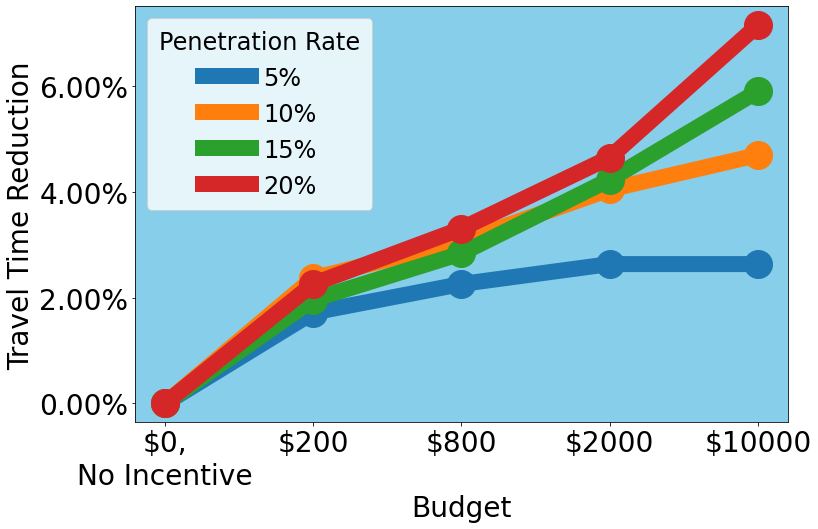

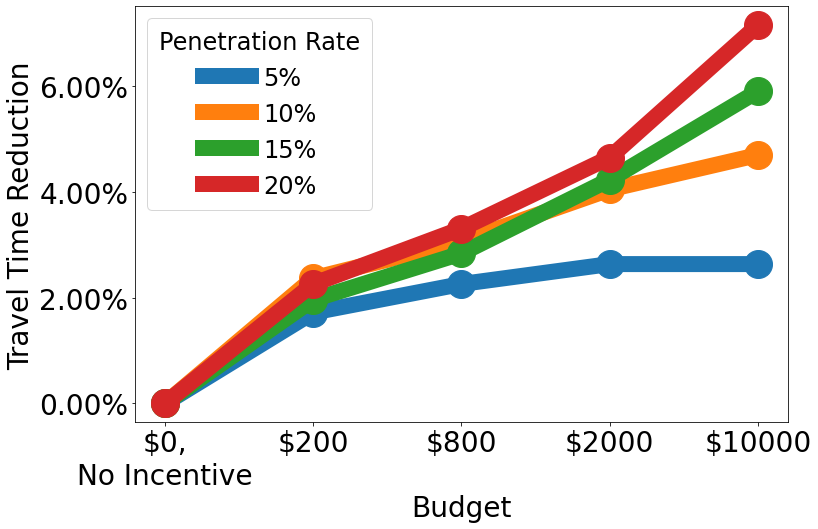

In [12]:
solver_names_setting = ["ADMM"]
percNonUVals_setting = [95, 90, 85, 80]
VOTs_setting = [2.63]
plot_tt_reduction_perc_new(budget_tt_reduction_plot_dict, \
                           solver_names = solver_names_setting, \
                           percNonUVals = percNonUVals_setting, \
                           VOTs = VOTs_setting, \
                           blueBack = True, 
                           large_size = False,
                          fontsize = 28,
                          )

plot_tt_reduction_perc_new(budget_tt_reduction_plot_dict, \
                           solver_names = solver_names_setting, \
                           percNonUVals = percNonUVals_setting, \
                           VOTs = VOTs_setting, \
                           blueBack = False, 
                           large_size = False,
                          fontsize = 28)

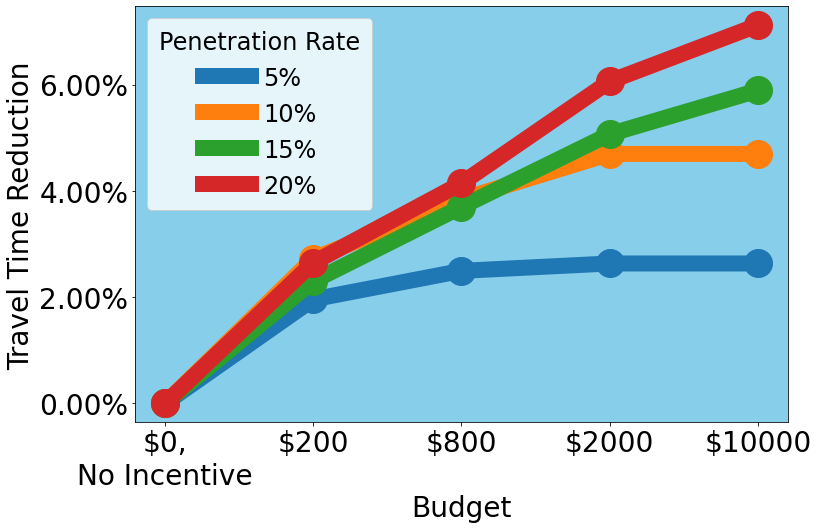

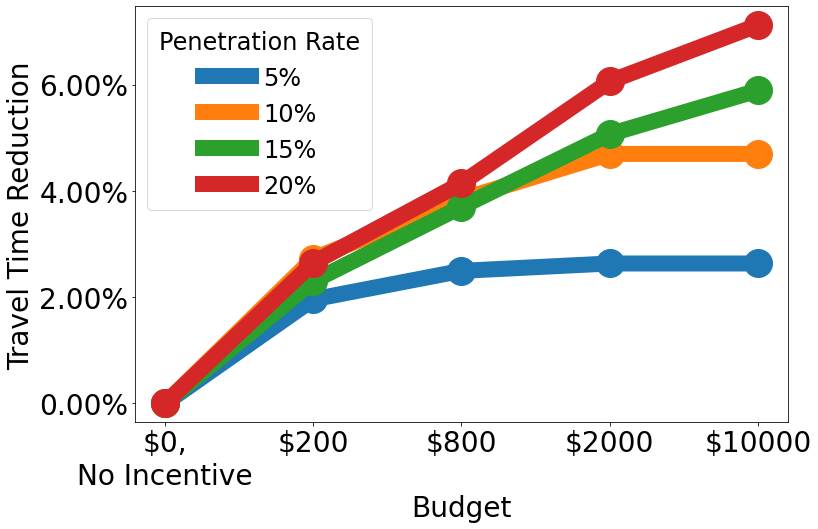

In [13]:
solver_names_setting = ["ADMM"]
percNonUVals_setting = [95, 90, 85, 80]
VOTs_setting = [1.315]
plot_tt_reduction_perc_new(budget_tt_reduction_plot_dict, \
                           solver_names = solver_names_setting, \
                           percNonUVals = percNonUVals_setting, \
                           VOTs = VOTs_setting, \
                           blueBack = True, 
                           large_size = False,
                          fontsize = 28)

plot_tt_reduction_perc_new(budget_tt_reduction_plot_dict, \
                           solver_names = solver_names_setting, \
                           percNonUVals = percNonUVals_setting, \
                           VOTs = VOTs_setting, \
                           blueBack = False, 
                           large_size = False,
                          fontsize = 28)

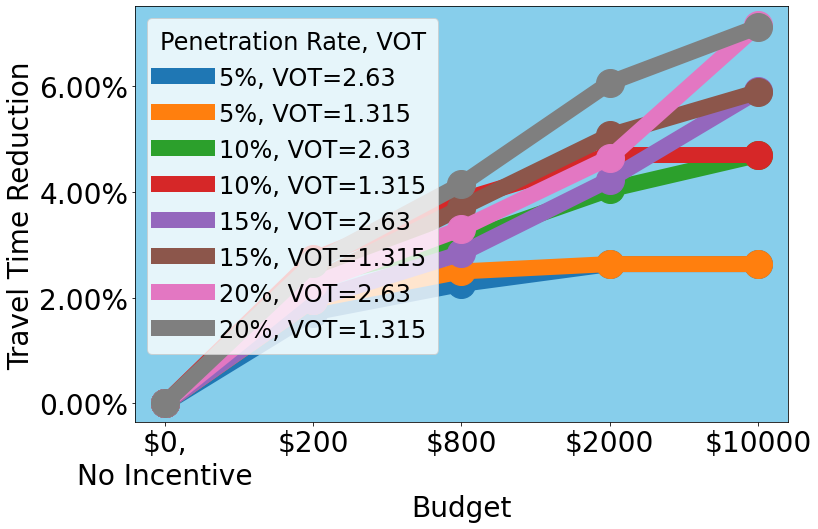

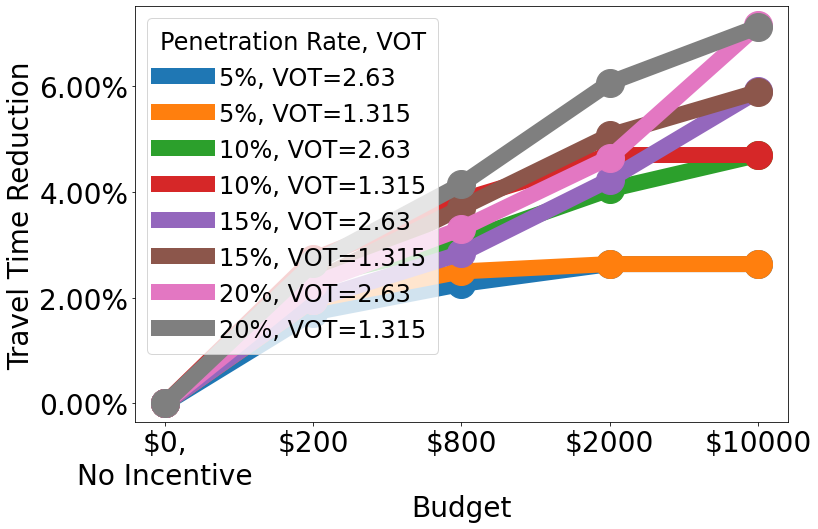

In [14]:
solver_names_setting = ["ADMM"]
percNonUVals_setting = [95, 90, 85, 80]
VOTs_setting = [2.63, 1.315]
plot_tt_reduction_perc_new(budget_tt_reduction_plot_dict, \
                           solver_names = solver_names_setting, \
                           percNonUVals = percNonUVals_setting, \
                           VOTs = VOTs_setting, \
                           blueBack = True, 
                           large_size = False,
                          fontsize = 28)

plot_tt_reduction_perc_new(budget_tt_reduction_plot_dict, \
                           solver_names = solver_names_setting, \
                           percNonUVals = percNonUVals_setting, \
                           VOTs = VOTs_setting, \
                           blueBack = False, 
                           large_size = False,
                          fontsize = 28)

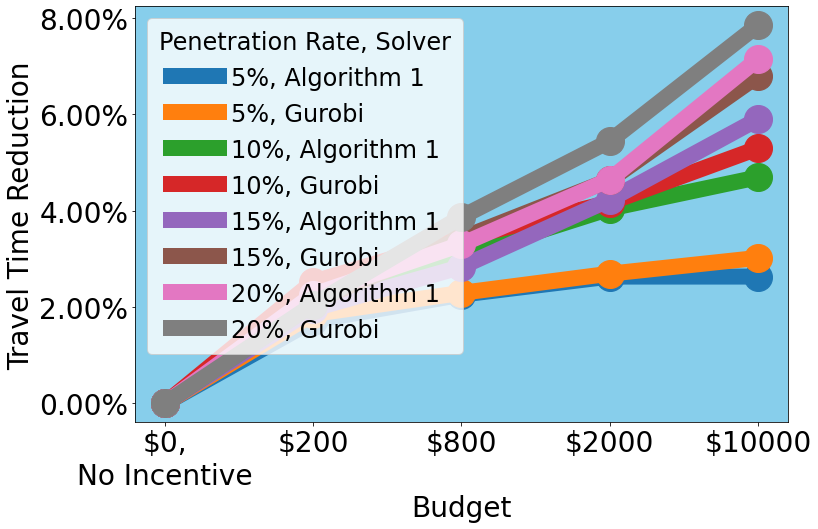

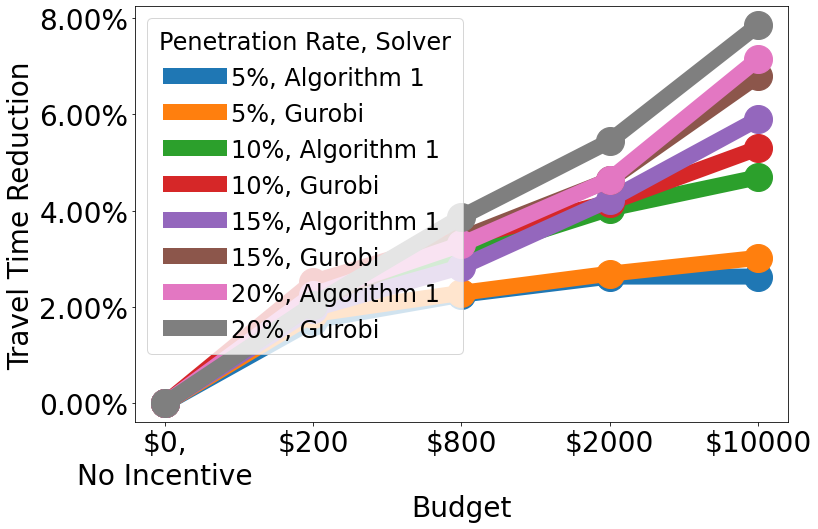

In [15]:
solver_names_setting = ["ADMM", "Gurobi"]
percNonUVals_setting = [95, 90, 85, 80, ]
VOTs_setting = [2.63]
plot_tt_reduction_perc_new(budget_tt_reduction_plot_dict, \
                           solver_names = solver_names_setting, \
                           percNonUVals = percNonUVals_setting, \
                           VOTs = VOTs_setting, \
                           blueBack = True, 
                           large_size = False,
                          fontsize = 28)
plot_tt_reduction_perc_new(budget_tt_reduction_plot_dict, \
                           solver_names = solver_names_setting, \
                           percNonUVals = percNonUVals_setting, \
                           VOTs = VOTs_setting, \
                           blueBack = False, 
                           large_size = False,
                          fontsize = 28)

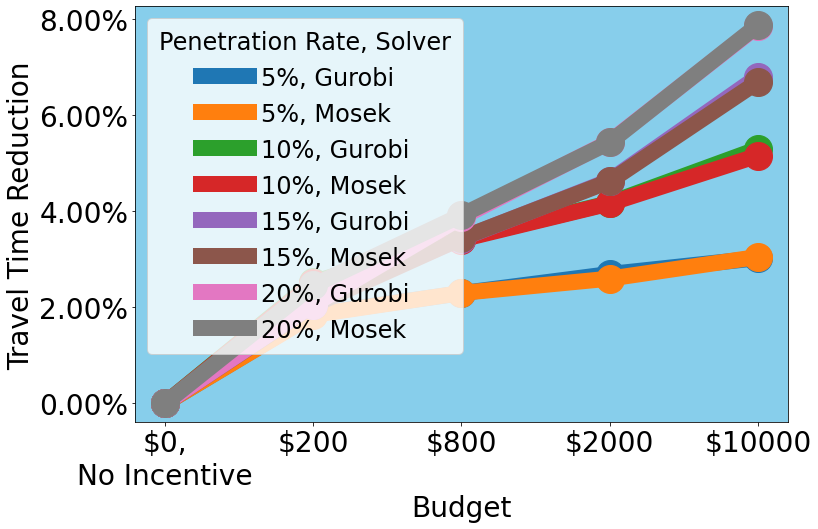

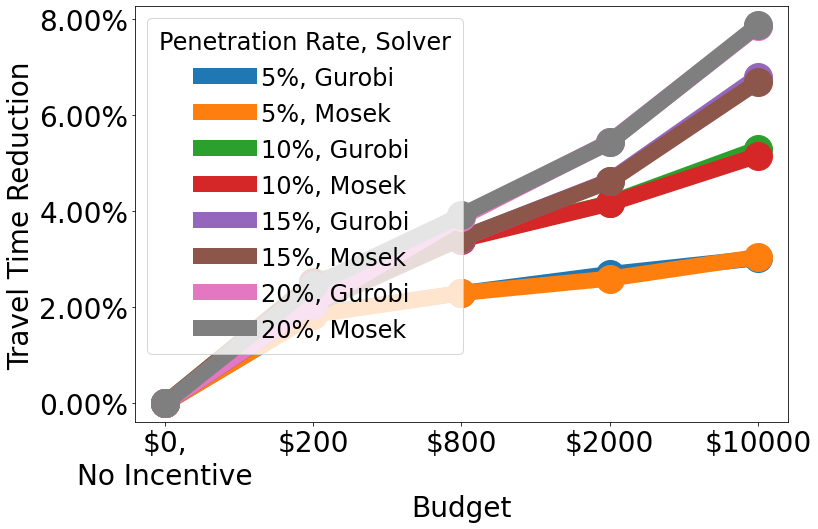

In [16]:
solver_names_setting = ["Mosek", "Gurobi"]
percNonUVals_setting = [95, 90, 85, 80, ]
VOTs_setting = [2.63]
plot_tt_reduction_perc_new(budget_tt_reduction_plot_dict, \
                           solver_names = solver_names_setting, \
                           percNonUVals = percNonUVals_setting, \
                           VOTs = VOTs_setting, \
                           blueBack = True, 
                           large_size = False,
                          fontsize = 28)
plot_tt_reduction_perc_new(budget_tt_reduction_plot_dict, \
                           solver_names = solver_names_setting, \
                           percNonUVals = percNonUVals_setting, \
                           VOTs = VOTs_setting, \
                           blueBack = False, 
                           large_size = False,
                          fontsize = 28)

## Plot Travel Time Decrease of Different Penetration Rates @ Different Budgets

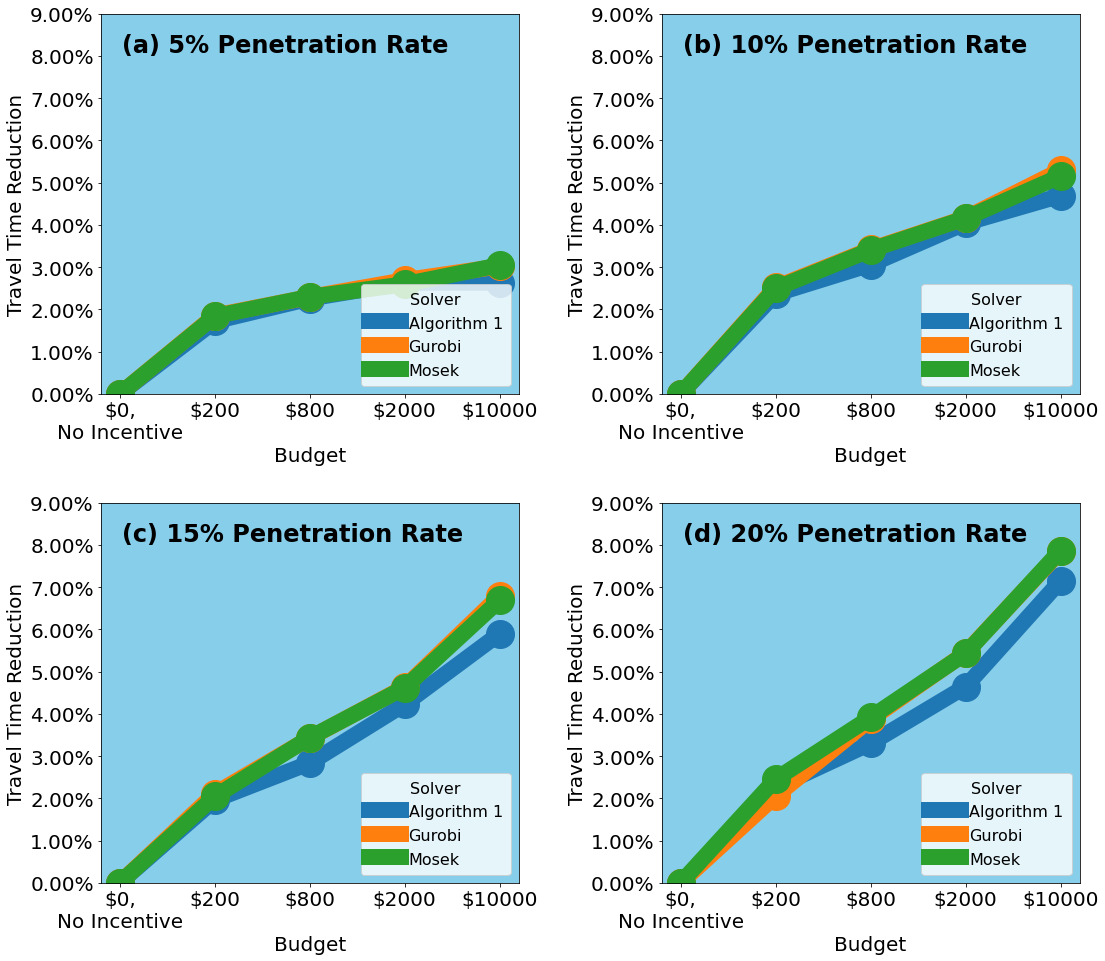

In [17]:
solver_names_setting = ["ADMM", "Gurobi", "Mosek"]
percNonUVals_setting = [95, 90, 85, 80]
# percNonUVals_setting = [95]
VOTs_setting = [2.63]
fontsize = 20
blueBack = True
largesize = False
plot_tt_reduction_perc_new_subplots_complete(budget_tt_reduction_plot_dict=budget_tt_reduction_plot_dict,
                                                 solver_names_setting=solver_names_setting,
                                                 percNonUVals_setting=percNonUVals_setting,
                                                 VOTs_setting=VOTs_setting,
                                                blueBack = True,
                                                largesize = False,
                                                fontsize = 20,)

## Plot Comparison of Travel Time Decrease 

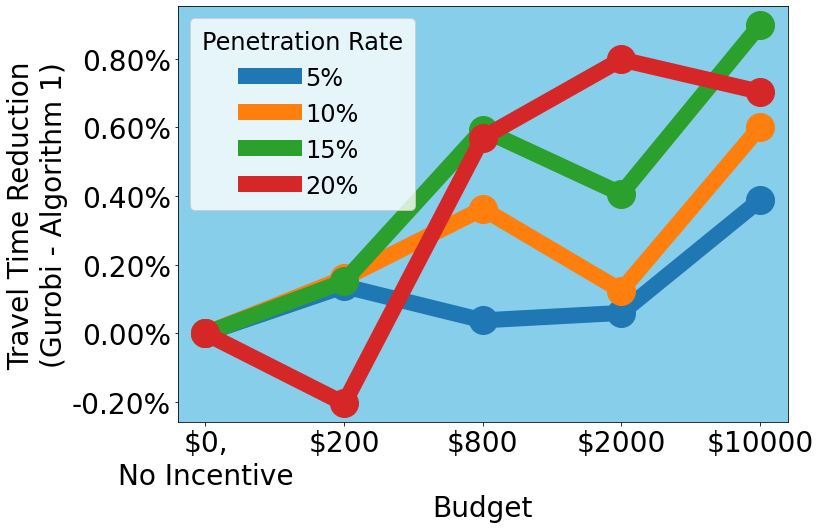

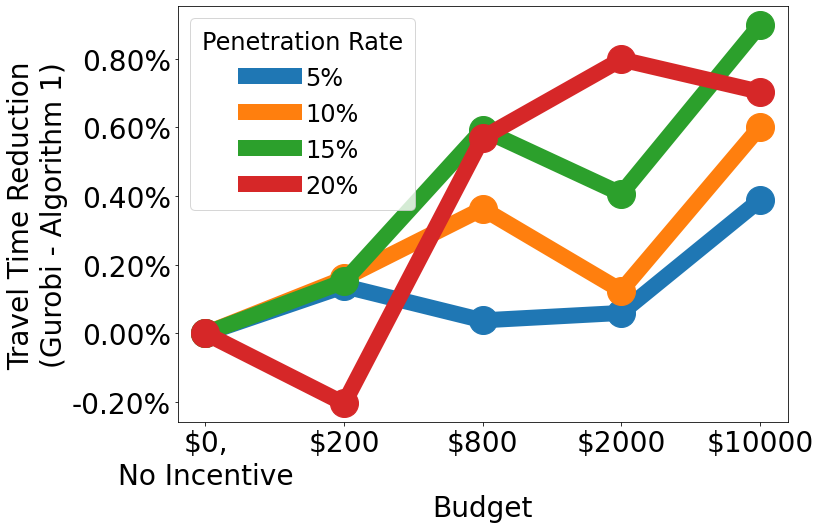

In [18]:
solver_name_setting1 = "Gurobi"
solver_name_setting2 = "ADMM"
percNonUVals_setting = [95, 90, 85, 80, ]
VOTs_setting = [2.63]
plot_tt_reduction_perc_comparison(budget_tt_reduction_plot_dict, \
                                   solver_name1 = solver_name_setting1, \
                                   solver_name2 = solver_name_setting2, \
                                   percNonUVals = percNonUVals_setting, \
                                   VOTs = VOTs_setting, \
                                   blueBack = True, 
                                   large_size = False,
                          fontsize = 28)
plot_tt_reduction_perc_comparison(budget_tt_reduction_plot_dict, \
                                   solver_name1 = solver_name_setting1, \
                                   solver_name2 = solver_name_setting2, \
                                   percNonUVals = percNonUVals_setting, \
                                   VOTs = VOTs_setting, \
                                   blueBack = False, 
                                   large_size = False,
                          fontsize = 28)

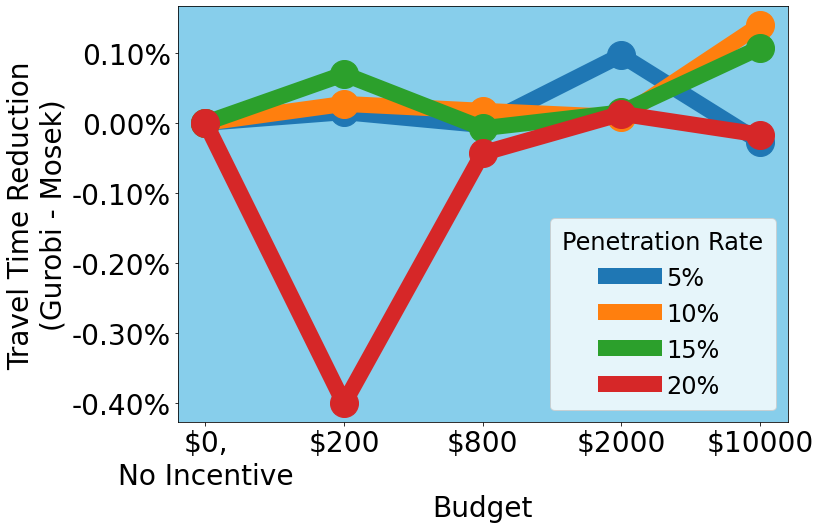

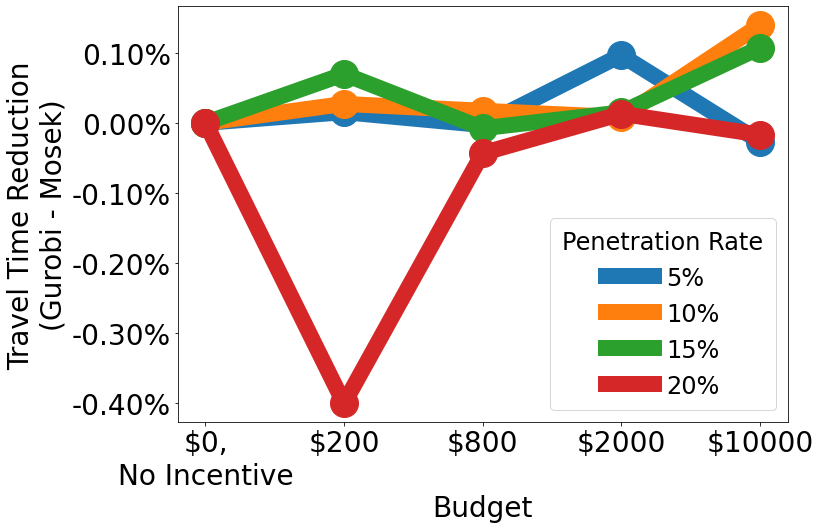

In [19]:
solver_name_setting1 = "Gurobi"
solver_name_setting2 = "Mosek"
percNonUVals_setting = [95, 90, 85, 80, ]
VOTs_setting = [2.63]
plot_tt_reduction_perc_comparison(budget_tt_reduction_plot_dict, \
                                   solver_name1 = solver_name_setting1, \
                                   solver_name2 = solver_name_setting2, \
                                   percNonUVals = percNonUVals_setting, \
                                   VOTs = VOTs_setting, \
                                   blueBack = True, 
                                   large_size = False,
                          fontsize = 28)
plot_tt_reduction_perc_comparison(budget_tt_reduction_plot_dict, \
                                   solver_name1 = solver_name_setting1, \
                                   solver_name2 = solver_name_setting2, \
                                   percNonUVals = percNonUVals_setting, \
                                   VOTs = VOTs_setting, \
                                   blueBack = False, 
                                   large_size = False,
                          fontsize = 28)

## Plot Comparison of Incentivization Costs

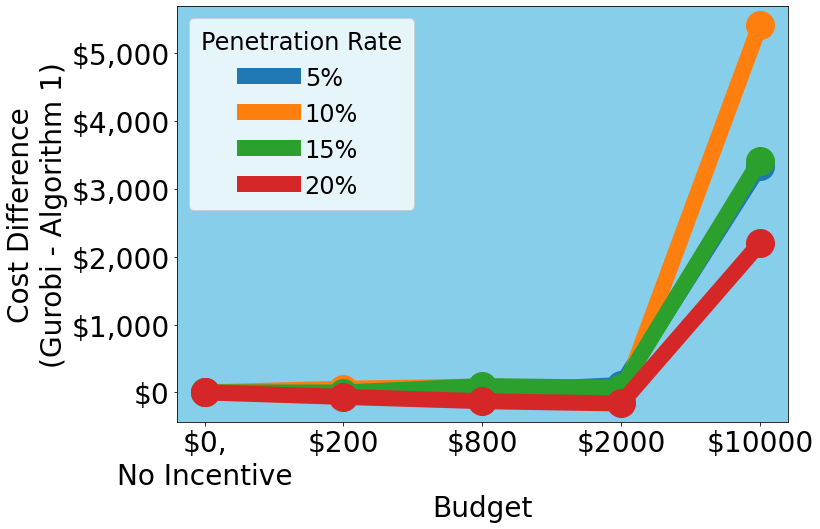

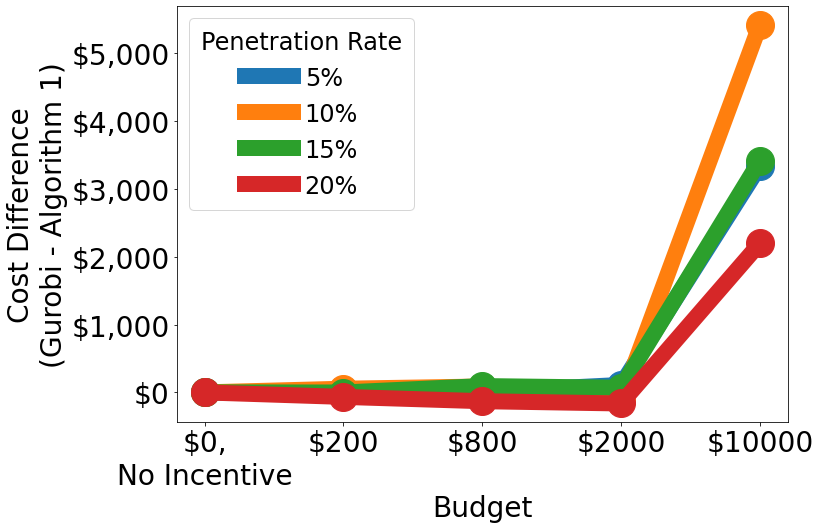

In [20]:
solver_name_setting1 = "Gurobi"
solver_name_setting2 = "ADMM"
percNonUVals_setting = [95, 90, 85, 80, ]
VOTs_setting = [2.63]
n_companies = [1]
plot_cost_comparison(budget_cost_plot_dict, \
                       solver_name1 = solver_name_setting1, \
                       solver_name2 = solver_name_setting2, \
                       n_companies = n_companies, \
                       percNonUVals = percNonUVals_setting, \
                       VOTs = VOTs_setting, \
                       blueBack = True, 
                       large_size = False,
                          fontsize = 28)
plot_cost_comparison(budget_cost_plot_dict, \
                       solver_name1 = solver_name_setting1, \
                       solver_name2 = solver_name_setting2, \
                       n_companies = n_companies, \
                       percNonUVals = percNonUVals_setting, \
                       VOTs = VOTs_setting, \
                       blueBack = False, 
                       large_size = False,
                          fontsize = 28)

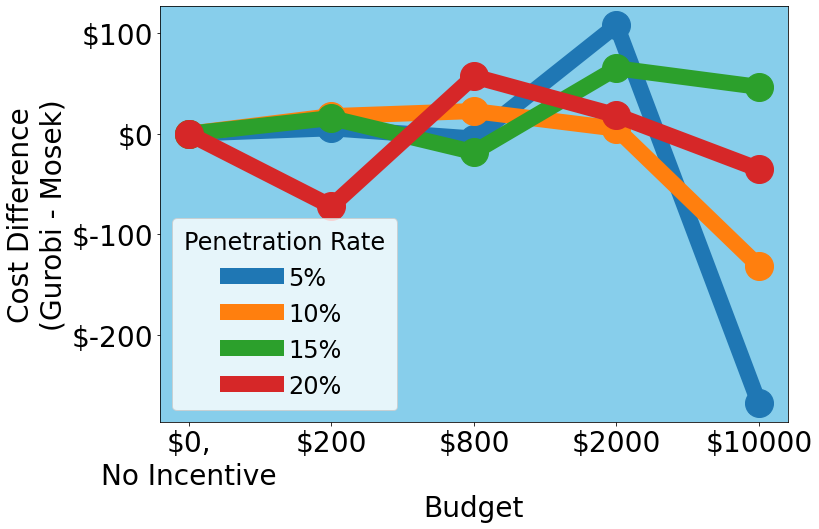

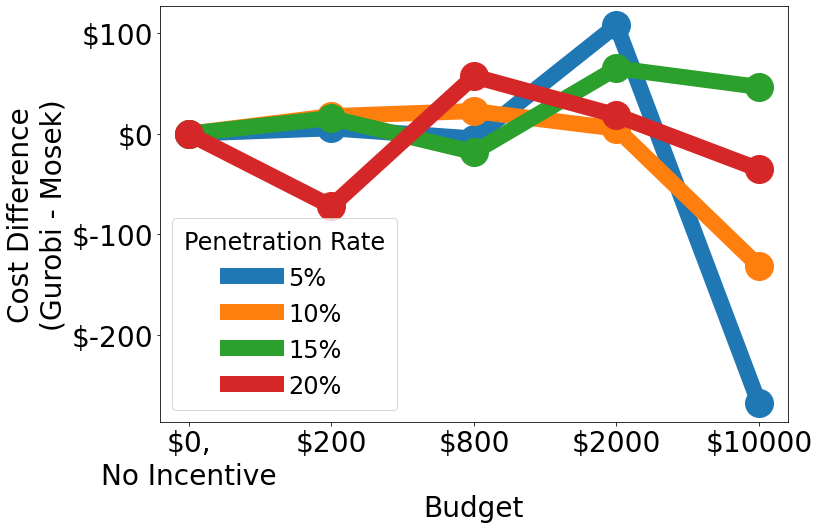

In [21]:
solver_name_setting1 = "Gurobi"
solver_name_setting2 = "Mosek"
# percNonUVals_setting = [80, ]
percNonUVals_setting = [95, 90, 85, 80, ]
VOTs_setting = [2.63]
n_companies = [1]
plot_cost_comparison(budget_cost_plot_dict, \
                       solver_name1 = solver_name_setting1, \
                       solver_name2 = solver_name_setting2, \
                       n_companies = n_companies, \
                       percNonUVals = percNonUVals_setting, \
                       VOTs = VOTs_setting, \
                       blueBack = True, 
                       large_size = False,
                          fontsize = 28)
plot_cost_comparison(budget_cost_plot_dict, \
                       solver_name1 = solver_name_setting1, \
                       solver_name2 = solver_name_setting2, \
                       n_companies = n_companies, \
                       percNonUVals = percNonUVals_setting, \
                       VOTs = VOTs_setting, \
                       blueBack = False, 
                       large_size = False,
                          fontsize = 28)

## Plot Total Incentivization Costs

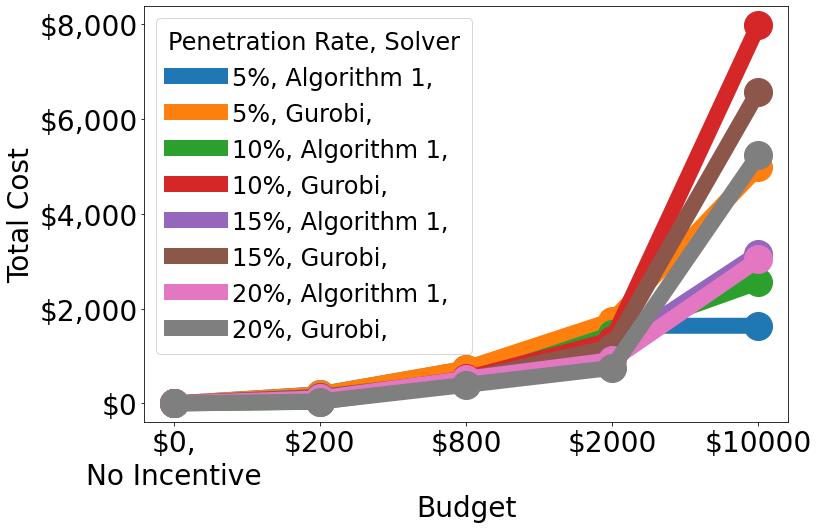

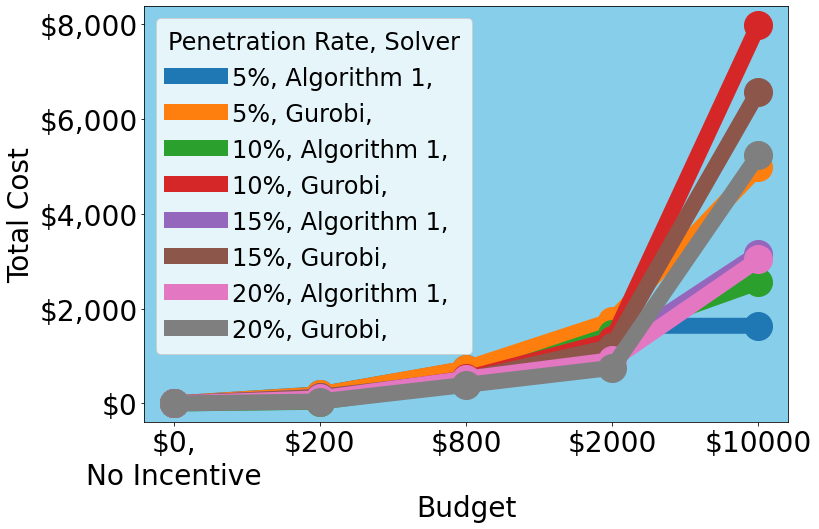

In [22]:
plot_cost_new(budget_cost_plot_dict, \
              solver_names=["ADMM", "Gurobi"], \
              percNonUVals = [95, 90, 85, 80], \
              VOTs = [2.63], \
              n_companies=[1], \
              factor = factor_cost_comparison,
              blueBack = False, 
             large_size = False,
                          fontsize = 28)
plot_cost_new(budget_cost_plot_dict, \
              solver_names=["ADMM", "Gurobi"], \
              percNonUVals = [95, 90, 85, 80], \
              VOTs = [2.63], \
              n_companies=[1], \
              factor = factor_cost_comparison,
              blueBack = True, 
             large_size = False,
                          fontsize = 28)


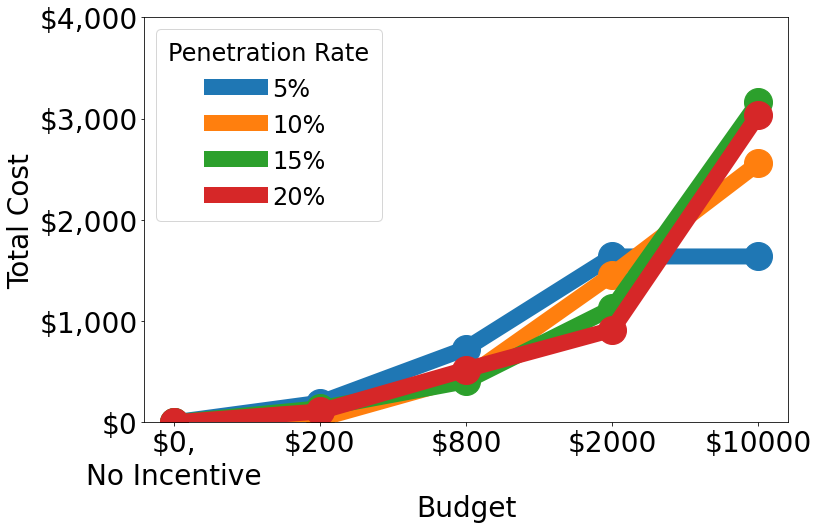

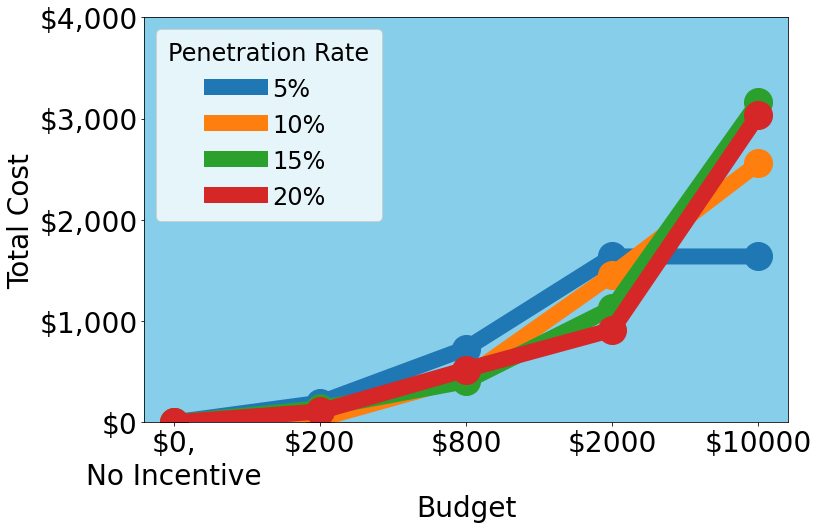

In [23]:
plot_cost_new(budget_cost_plot_dict, \
              solver_names=["ADMM"], \
              percNonUVals = [95, 90, 85, 80], \
              VOTs = [2.63], \
              n_companies=[1], \
              factor = factor_cost_comparison,
              blueBack = False, 
             large_size = False,
                          fontsize = 28)
plot_cost_new(budget_cost_plot_dict, \
              solver_names=["ADMM"], \
              percNonUVals = [95, 90, 85, 80], \
              VOTs = [2.63], \
              n_companies=[1], \
              factor = factor_cost_comparison,
              blueBack = True, 
             large_size = False,
                          fontsize = 28)


## Plot Incentivization Costs Per Driver

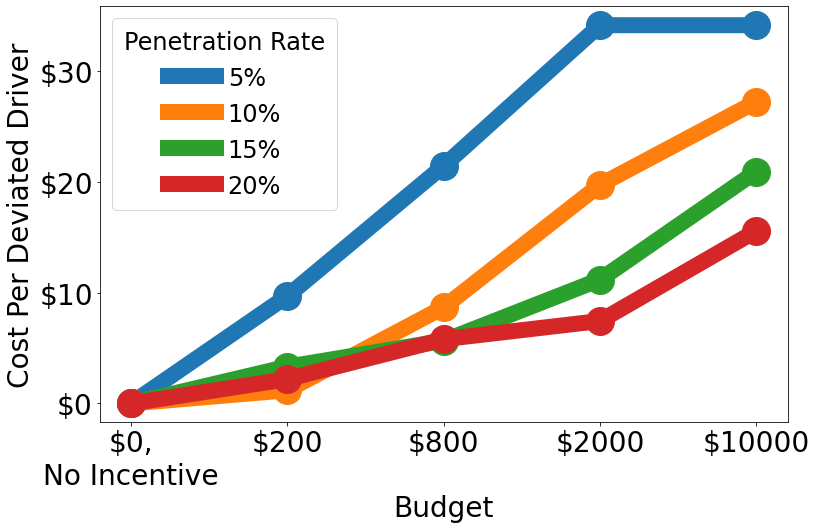

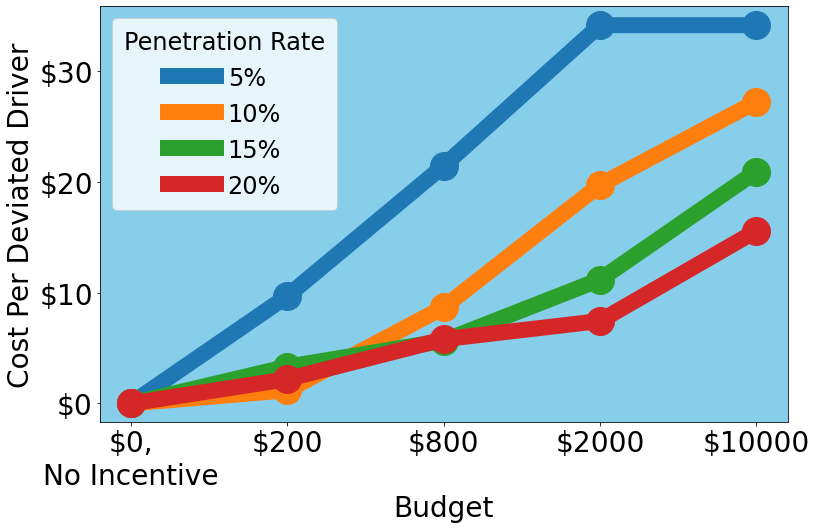

In [24]:
plot_cost_per_driver_new(budget_cost_per_deviated_plot_dict, \
                          solver_names=["ADMM"], \
                          percNonUVals = [95, 90, 85, 80, ], \
                          VOTs = [2.63], \
                          n_companies=[1], \
                          factor = factor_cost_comparison,
                         blueBack = False,
                         large_size = False,
                          fontsize = 28)
plot_cost_per_driver_new(budget_cost_per_deviated_plot_dict, \
                          solver_names=["ADMM"], \
                          percNonUVals = [95, 90, 85, 80, ], \
                          VOTs = [2.63], \
                          n_companies=[1], \
                          factor = factor_cost_comparison,
                         blueBack = True,
                         large_size = False,
                          fontsize = 28)

## Plot Travel Time Reduction Cost @ Different Number of Organizations

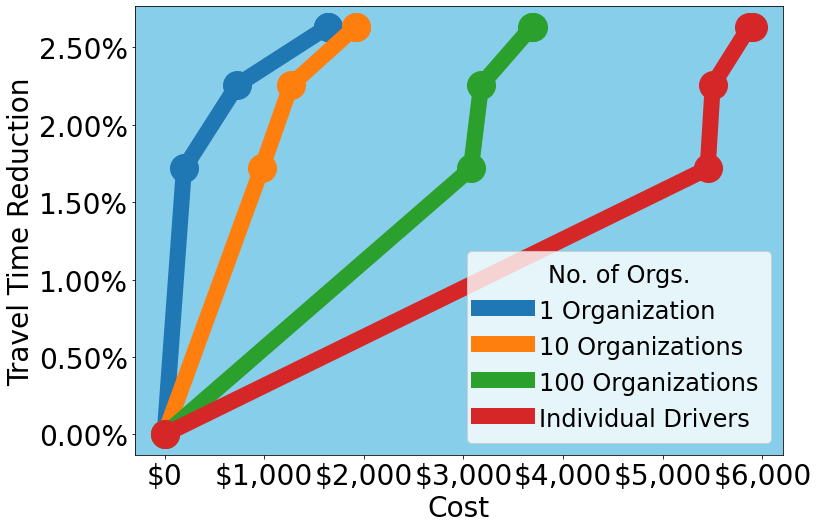

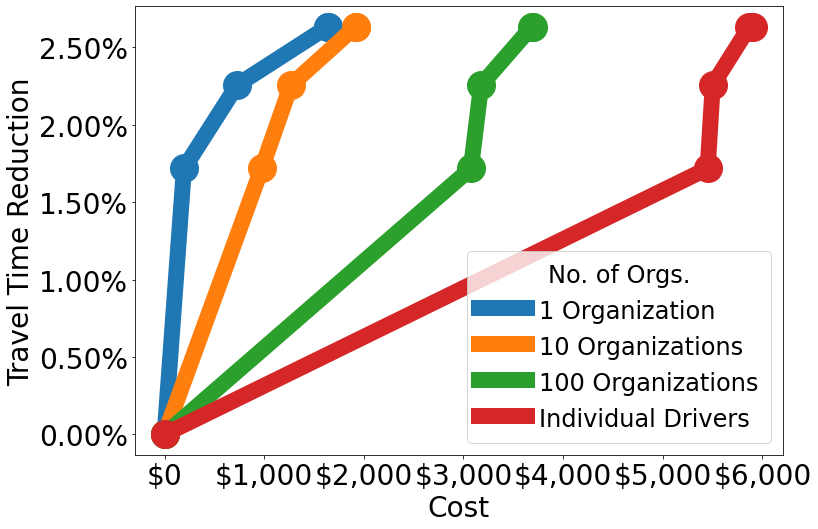

In [25]:
plot_cost_tt_reduction_new(cost_tt_reduction_plot_dict, \
                           solver_names=["ADMM"], \
                           percNonUVals = [95], \
                           VOTs = [2.63], \
                           factor = factor_cost_comparison, \
                           blueBack = True,
                          large_size = False,
                          fontsize = 28)
plot_cost_tt_reduction_new(cost_tt_reduction_plot_dict, \
                           solver_names=["ADMM"], \
                           percNonUVals = [95], \
                           VOTs = [2.63], \
                           factor = factor_cost_comparison, \
                           blueBack = False,
                          large_size = False,
                          fontsize = 28)